# Multiclass Perceptron and SVM

In this notebook, we'll try out the multiclass Perceptron and SVM on small data sets.

## 1. Multiclass Perceptron

Let's start with the code for the multiclass Perceptron algorithm. This is similar in spirit to our earlier binary Perceptron algorithm, except that now there is a linear function for each class.

If there are `k` classes, we will assume that they are numbered `0,1,...,k-1`. For `d`-dimensional data, the classifier will be parametrized by:
* `w`: this is a `kxd` numpy array with one row for each class
* `b`: this is a `k`-dimensional numpy array with one offset for each class

Thus the linear function for class `j` (where `j` lies in the range `0` to `k-1`) is given by `w[j,:], b[j]`.

The first procedure, **evaluate_classifier**, takes as input the parameters of a linear classifier (`w,b`) as well as a data point (`x`) and returns the prediction of that classifier at `x`.

In [1]:
def evaluate_classifier(w,b,x):
    k = len(b)
    scores = np.zeros(k)
    for j in range(k):
        scores[j] = np.dot(w[j,:],x) + b[j]
    return int(np.argmax(scores))

Here is the multiclass Perceptron training procedure. It is invoked as follows:
* `w,b,converged = train_multiclass_perceptron(x,y,k,n_iters)`

where
* `x`: n-by-d numpy array with n data points, each d-dimensional
* `y`: n-dimensional numpy array with the labels (in the range `0` to `k-1`)
* `k`: the number of classes
* `n_iters`: the training procedure will run through the data at most this many times (default: 100)
* `w,b`: parameters for the final linear classifier, as above
* `converged`: flag (True/False) indicating whether the algorithm converged within the prescribed number of iterations

If the data is not linearly separable, then the training procedure will not converge.

In [2]:
def train_multiclass_perceptron(x,y,k,n_iters=100):
    n,d = x.shape
    w = np.zeros((k,d))
    b = np.zeros(k)
    done = False
    converged = True
    iters = 0
    np.random.seed(None)
    while not(done):
        done = True
        I = np.random.permutation(n)
        for j in I:
            pred_y = evaluate_classifier(w,b,x[j,:])
            true_y = int(y[j])
            if pred_y != true_y:
                w[true_y,:] = w[true_y,:] + x[j,:]
                b[true_y] = b[true_y] + 1.0
                w[pred_y,:] = w[pred_y,:] - x[j,:]
                b[pred_y] = b[pred_y] - 1.0
                done = False
        iters = iters + 1
        if iters > n_iters:
            done = True
            converged = False
    if converged:
        print("Perceptron algorithm: iterations until convergence: ", iters)
    else:
        print("Perceptron algorithm: did not converge within the specified number of iterations")
    return w, b, converged

## 2. Experiments with multiclass Perceptron

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
#same as in svm notebook
import warnings; warnings.simplefilter('ignore')

This next routine takes as input a two-dimensional data set as well as a classifier. It plots the points, with different colors for different labels, and shows the decision boundaries of the classifier. It is invoked as follows:
* `display_data_and_boundary(x,y,pred_fn)`

where
* `x` and `y` are the two-dimensional data and their labels (in the range `0,...,k-1`)
* `pred_fn` is the classifier: it is a function that takes a data point and returns a label

In [4]:
def display_data_and_boundary(x,y,pred_fn):
    # Determine the x1- and x2- limits of the plot
    x1min = min(x[:,0]) - 1
    x1max = max(x[:,0]) + 1
    x2min = min(x[:,1]) - 1
    x2max = max(x[:,1]) + 1
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
    # Plot the data points
    k = int(max(y)) + 1
    cols = ['ro', 'k^', 'b*','gx']
    for label in range(k):
        plt.plot(x[(y==label),0], x[(y==label),1], cols[label%4], markersize=8)
    # Construct a grid of points at which to evaluate the classifier
    grid_spacing = 0.05
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_spacing), np.arange(x2min, x2max, grid_spacing))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Z = np.array([pred_fn(pt) for pt in grid])
    # Show the classifier's boundary using a color plot
    Z = Z.reshape(xx1.shape)
    plt.pcolormesh(xx1, xx2, Z, cmap=plt.cm.Pastel1, vmin=0, vmax=k)
    plt.show()

The following procedure, **run_multiclass_perceptron**, loads a labeled two-dimensional data set, learns a linear classifier using the Perceptron algorithm, and then displays the data as well as the boundary.

The data file is assumed to contain one data point per line, along with a label, like:
* `3 8 2` (meaning that point `x=(3,8)` has label `y=2`)

In [5]:
def run_multiclass_perceptron(datafile):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    k = int(max(y)) + 1
    print("Number of classes: ", k)
    # Run the Perceptron algorithm for at most 1000 iterations
    w,b,converged = train_multiclass_perceptron(x,y,k,1000)
    # Show the data and boundary
    pred_fn = lambda p: evaluate_classifier(w,b,p)
    display_data_and_boundary(x,y,pred_fn)

Let's try this out on two simple data sets. Make sure that the directory containing this notebook also contains the two-dimensional data files `data_3.txt` and `data_4.txt`. You should run these next two cells a few times to get a sense of the variability of the outcome.

In [ ]:
run_multiclass_perceptron('data_3.txt')

Number of classes:  4
Perceptron algorithm: iterations until convergence:  16


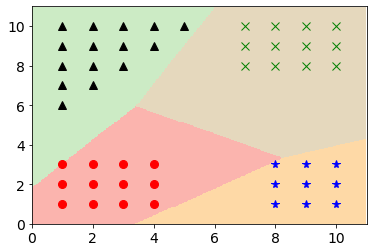

In [6]:
run_multiclass_perceptron('data_3.txt')

Number of classes:  3
Perceptron algorithm: iterations until convergence:  52


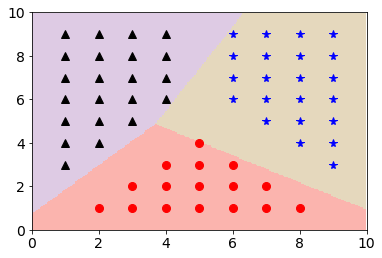

In [8]:
run_multiclass_perceptron('data_4.txt')

## 3. Experiments with multiclass SVM

Now let's see how multiclass SVM fares on these same data sets. We start with an analog of the **run_multiclass_perceptron** function. The key difference is that the SVM version, **run_multiclass_svm**, takes a second parameter: the regularization constant `C` in the convex program of the soft-margin SVM.

In [26]:
from sklearn.svm import SVC, LinearSVC
def run_multiclass_svm(datafile,C_value= 1):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    k = int(max(y)) + 1
    print("Number of classes: ", k)
    # Train an SVM
    clf = LinearSVC(loss='hinge', multi_class='crammer_singer', C=C_value)
    clf.fit(x,y)
    # Show the data and boundary
    pred_fn = lambda p: clf.predict(p.reshape(1,-1))    
    display_data_and_boundary(x,y,pred_fn)

Let's run this on the two data sets `data_3.txt` and `data_4.txt` that we saw earlier. Try playing with the second parameter to see how the decision boundary changes. You should try values like `C = 0.01, 0.1, 1.0, 10.0, 100.0`.

Number of classes:  4


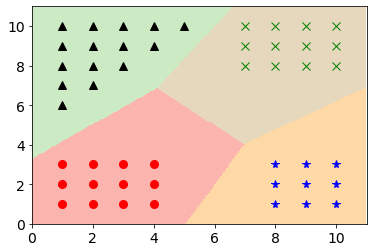

In [22]:
run_multiclass_svm('data_3.txt',100.0)

Number of classes:  4


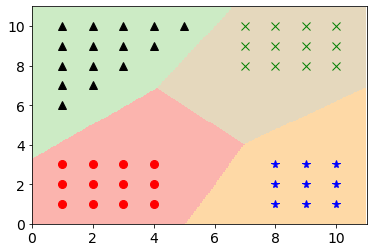

In [24]:
run_multiclass_svm('data_3.txt',10.0)

Number of classes:  4


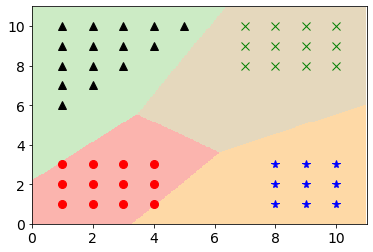

In [28]:
run_multiclass_svm('data_3.txt', 0.1)

Number of classes:  4


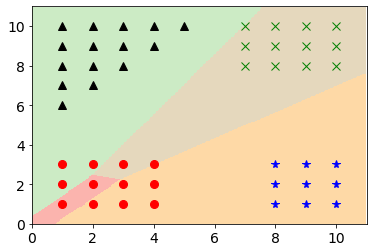

In [19]:
run_multiclass_svm('data_3.txt',0.01)

Number of classes:  3


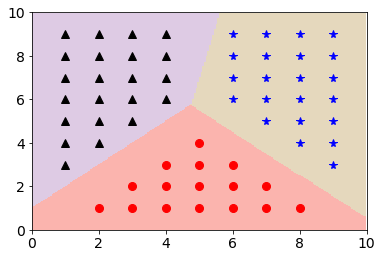

In [32]:
run_multiclass_svm('data_4.txt',10)

<font color="magenta">For you to think about:</font> How would you summarize the effect of varying `C`?

The final experiment is with the famous IRIS data set. This is four-dimensional data with three labels, but we will pick just two of the features, as a consequence of which the problem is not linearly separable. Thus the Perceptron algorithm would never converge. The soft-margin SVM obtains a reasonable solution, however.

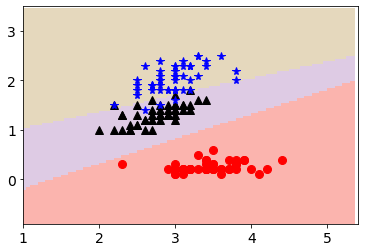

In [33]:
# Load IRIS data
from sklearn import datasets
iris = datasets.load_iris()
x = iris.data
y = iris.target
# Select just two of the four features
features = [1,3]
x = x[:,features]
# Train SVM
clf = LinearSVC(loss='hinge', multi_class='crammer_singer')
clf.fit(x,y)
pred_fn = lambda p: clf.predict(p.reshape(1,-1))
display_data_and_boundary(x,y,pred_fn)